In [8]:
# 构建PLTS
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
Data=pd.DataFrame()
indexes={'舒适':0,'耐久':0,'精细':0,'保障':0,'牌证':0,'外观':0,'外部':0,'响应及时性':0,'沟通有效性':0,'信息安全性':0,'补偿合理性':0,'服务专业性':0}
pinpais=['ALBD','AND','AT','BNL','GRN','LN','QPL','TB']
for pinpai in pinpais:
    data=pd.read_csv('D:\python_common\代码_感知质量大论文\公开数据处理\感知质量数据集\维度-情感分类结果_\维度-情感分类结果2_'+pinpai+'.tsv',sep='\t',header=None)
    data.columns=['类别',' ']
    data['品牌']=[pinpai]*len(data)
    data['维度']=data['类别'].apply(lambda x:x[0:2])
    data['情感']=data['类别'].apply(lambda x:x[-1])
    data=data.drop(['类别'],axis=1)
    Data=Data.append(data)
PLTS={'舒适':0,'耐久':0,'精细':0,'保障':0,'牌证':0,'外观':0,'外部':0,'响应':0,'沟通':0,'信息':0,'补偿':0,'服务':0}
for each in PLTS.keys():
    data=Data[Data['维度']==each].value_counts(['品牌','情感']).unstack().T
    data=data/data.sum()
    data=data.T.stack().reset_index(['品牌','情感'])
    data.columns=['品牌','情感','比例']
    PLTS[each]=data
print(PLTS)

{'舒适':       品牌 情感        比例
0   ALBD  1  0.055834
1   ALBD  2  0.274157
2   ALBD  3  0.670009
3    AND  1  0.051054
4    AND  2  0.276815
5    AND  3  0.672131
6     AT  1  0.092798
7     AT  2  0.286365
8     AT  3  0.620837
9    BNL  1  0.069869
10   BNL  2  0.247453
11   BNL  3  0.682678
12   GRN  1  0.067167
13   GRN  2  0.212992
14   GRN  3  0.719841
15    LN  1  0.115842
16    LN  2  0.340842
17    LN  3  0.543317
18   QPL  1  0.069918
19   QPL  2  0.302259
20   QPL  3  0.627823
21    TB  1  0.070463
22    TB  2  0.230051
23    TB  3  0.699485, '耐久':       品牌 情感        比例
0   ALBD  1  0.407643
1   ALBD  2  0.101911
2   ALBD  3  0.490446
3    AND  1  0.382470
4    AND  2  0.111554
5    AND  3  0.505976
6     AT  1  0.501229
7     AT  2  0.154791
8     AT  3  0.343980
9    BNL  1  0.448473
10   BNL  2  0.135496
11   BNL  3  0.416031
12   GRN  1  0.521595
13   GRN  2  0.096346
14   GRN  3  0.382060
15    LN  1  0.531792
16    LN  2  0.158960
17    LN  3  0.309249
18   QPL  1  0.486

In [9]:
import os
if not os.path.exists('随机占优积分过程'):
    os.mkdir('随机占优积分过程')
for weidu in PLTS.keys():
    DATA=PLTS[weidu].set_index(['品牌','情感']).unstack().fillna(0).T.to_numpy()
    pd.DataFrame(DATA,index=['消极','中性','积极'],columns=pinpais).to_csv('./随机占优积分过程/A比例_'+weidu+'.csv',index=['消极','中性','积极'])

In [10]:
# F函数返回各维度的概率分布函数，x情感值，k维度
def F(k,x,DATA):
    summ=0
    for i in range(0,x+1):
        summ=summ+DATA[i][k]
    return summ
def ssd(F,k,x,DATA):
    summ=0
    for i in range(0,x+1):
        summ=summ+F(k,i,DATA)
    return summ
def tsd(F,k,x,DATA):
    summ=0
    for i in range(0,x+1):
        summ=summ+ssd(F,k,i,DATA)
    return summ
def suiji(k1,k2,DATA):
    dataframe=pd.DataFrame({'flag1':[],'flag2':[],'flag3':[],})
    E=np.zeros(len(pinpais))
    for j in range(0,len(pinpais)):
        E[j]=np.sum([DATA[i][j]*(i+1) for i in [0,1,2]])
    for i in np.arange(0,3):
        dataframe.loc[i]=[F(k1,i,DATA)-F(k2,i,DATA),ssd(F,k1,i,DATA)-ssd(F,k2,i,DATA),tsd(F,k1,i,DATA)-tsd(F,k2,i,DATA)]
    if dataframe.loc[dataframe["flag1"]>0].empty:
        return 'FSD'
    elif dataframe.loc[dataframe["flag2"]>0].empty:
        return 'SSD'
    elif dataframe.loc[dataframe["flag3"]>0].empty and E[k1]>E[k2]:
        return 'TSD'
    else:
        return '--'
def sur(k1,h1,ss,DATA):
    # k占优于h
    data=DATA.T.cumsum(axis=1)
    if  ss[k1,h1] in ['FSD','SSD','TSD']:
        S1=0;S2=0;S3=0
        for i in range(0,3):
            S1=S1+data[h1][i]
            if data[h1][i]>data[k1][i]:
                S2=S2+data[h1][i]-data[k1][i]
            elif data[h1][i]<data[k1][i]:
                S3=S3+data[k1][i]-data[h1][i]
        return (S2-S3)/S1
    else:
        return '--'

def Hasses(ss):
    result=[]
    for i in range(0,len(ss)):
        Fs=0;Os=0
        for j in range(0,len(ss)):
            if ss[i,j] in ['FSD','SSD','TSD']:
                Fs+=1
            if ss[j,i] in ['FSD','SSD','TSD']:
                Os+=1
        try:
            result.append(round((len(ss)+1)*Os/(Fs+Os),2))
        except:
            result.append(0)
    return result

H=[]
for weidu in PLTS.keys():
    # 随机占优关系
    DATA=PLTS[weidu].set_index(['品牌','情感']).unstack().fillna(0).T.to_numpy()
    ss=np.array([['None'] * len(pinpais)]* len(pinpais))
    for i in range(0,len(pinpais)):
        for j in range(0,len(pinpais)):
            ss[i,j]='--' if i==j else suiji(i,j,DATA)
    pd.DataFrame(ss,index=pinpais,columns=pinpais).to_csv('./随机占优积分过程/B随机占优关系_'+weidu+'.csv')
    # 随机占优程度
    SUR=np.array([['None'] * len(pinpais)]* len(pinpais))
    for i in range(0,len(pinpais)):
        for j in range(0,len(pinpais)):
            SUR[i,j]=sur(i,j,ss,DATA)
    pd.DataFrame(SUR).to_csv('./随机占优积分过程/C随机占程度_'+weidu+'.csv')
    # HASSE图构建
    H.append(Hasses(ss))
    print(ss)
print('秩均值矩阵_待处理',H,sep='\n')

[['--' '--' 'FSD' 'SSD' '--' 'FSD' 'FSD' '--']
 ['FSD' '--' 'FSD' 'SSD' '--' 'FSD' 'FSD' '--']
 ['--' '--' '--' '--' '--' 'FSD' '--' '--']
 ['--' '--' 'FSD' '--' '--' 'FSD' 'FSD' '--']
 ['--' '--' 'FSD' 'FSD' '--' 'FSD' 'FSD' 'FSD']
 ['--' '--' '--' '--' '--' '--' '--' '--']
 ['--' '--' 'FSD' '--' '--' 'FSD' '--' '--']
 ['--' '--' 'FSD' '--' '--' 'FSD' '--' '--']]
[['--' '--' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD' '--']
 ['FSD' '--' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD' '--']
 ['--' '--' '--' '--' '--' 'FSD' '--' '--']
 ['--' '--' 'FSD' '--' 'FSD' 'FSD' 'FSD' '--']
 ['--' '--' '--' '--' '--' 'FSD' '--' '--']
 ['--' '--' '--' '--' '--' '--' '--' '--']
 ['--' '--' '--' '--' '--' 'SSD' '--' '--']
 ['FSD' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD' '--']]
[['--' '--' 'FSD' 'FSD' '--' 'FSD' 'FSD' '--']
 ['FSD' '--' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD' 'FSD']
 ['--' '--' '--' 'FSD' '--' 'FSD' 'FSD' '--']
 ['--' '--' '--' '--' '--' '--' '--' '--']
 ['--' '--' 'FSD' 'FSD' '--' 'FSD' 'FSD' '--']
 ['--' '--' '--' '--' '--' '--

In [16]:
# 调整
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def boolen_multi(A,B):
    C=np.array([[0] * len(A)]*len(A))
    for i in range(0,len(A)):
        for j in range(0,len(A)):
            for k in range(0,len(A)):
                C[i, j] += np.dot(A[i, k], B[k, j])
            if C[i,j]>0:
                C[i,j]=1
    return C

# 秩均值矩阵1
zhijunzhi1=np.array(H).T
print('秩均值矩阵1',zhijunzhi1,sep='\n');pd.DataFrame(zhijunzhi1,index=pinpais,columns=PLTS.keys()).to_csv('./随机占优积分过程/D秩均值矩阵1.csv')

# 计算各个维度的数量,调整维度的顺序,得到矩阵Matrix用于调整评价集,维度交换矩阵
pinpais=['ALBD','AND','AT','BNL','GRN','LN','QPL','TB']
Data=pd.DataFrame()
for pinpai in pinpais:
    data=pd.read_csv('D:\python_common\代码_感知质量大论文\公开数据处理\感知质量数据集\维度-情感分类结果_\维度-情感分类结果2_'+pinpai+'.tsv',sep='\t',header=None)
    data.columns=['类别',' ']
    data['品牌']=[pinpai]*len(data)
    data['维度']=data['类别'].apply(lambda x:x[0:2])
    data['情感']=data['类别'].apply(lambda x:x[-1])
    data=data.drop(['类别'],axis=1)
    Data=Data.append(data)
print(Data)
Data1=Data.value_counts('维度',sort=False)
print(Data1,type(Data1))
Data2=Data.value_counts('维度',sort=True)
print('调整前排序',Data1.index.values)
print('调整后排序',Data2.index.values)

秩均值矩阵1
[[1.8  2.57 3.   7.71 2.57 5.14 1.29 3.86 2.57 4.5  1.29 5.14]
 [0.   1.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [7.71 7.2  5.14 6.   7.2  3.86 6.   1.5  3.86 1.29 6.   1.5 ]
 [4.5  3.86 9.   3.86 1.29 7.5  7.5  7.71 9.   9.   9.   9.  ]
 [0.   7.2  3.   2.57 7.2  0.   4.5  5.14 1.29 9.   6.   1.8 ]
 [9.   9.   7.5  9.   5.4  7.5  9.   6.43 6.43 5.4  3.   7.5 ]
 [6.   7.2  9.   6.   9.   9.   6.75 9.   7.71 2.57 3.   7.5 ]
 [3.   0.   1.29 1.29 5.4  2.57 2.57 1.5  5.14 6.   7.71 3.  ]]
             品牌  维度 情感
0     NaN  ALBD  沟通  2
1     NaN  ALBD  舒适  3
2     NaN  ALBD  精细  3
3     NaN  ALBD  舒适  3
4     NaN  ALBD  精细  3
...    ..   ...  .. ..
19112 NaN    TB  保障  3
19113 NaN    TB  外观  3
19114 NaN    TB  精细  3
19115 NaN    TB  舒适  2
19116 NaN    TB  外部  3

[150642 rows x 4 columns]
维度
保障    22155
信息      348
响应     2103
外观    16770
外部    31287
服务    15201
沟通     4253
牌证      499
精细    26765
耐久     2606
舒适    27731
补偿      924
dtype: int64 <class 'pandas.core.serie

秩均值矩阵1
[[1.8  2.57 3.   7.71 2.57 5.14 1.29 3.86 2.57 4.5  1.29 5.14]
 [0.   1.29 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [7.71 7.2  5.14 6.   7.2  3.86 6.   1.5  3.86 1.29 6.   1.5 ]
 [4.5  3.86 9.   3.86 1.29 7.5  7.5  7.71 9.   9.   9.   9.  ]
 [0.   7.2  3.   2.57 7.2  0.   4.5  5.14 1.29 9.   6.   1.8 ]
 [9.   9.   7.5  9.   5.4  7.5  9.   6.43 6.43 5.4  3.   7.5 ]
 [6.   7.2  9.   6.   9.   9.   6.75 9.   7.71 2.57 3.   7.5 ]
 [3.   0.   1.29 1.29 5.4  2.57 2.57 1.5  5.14 6.   7.71 3.  ]]
             品牌  维度 情感
0     NaN  ALBD  沟通  2
1     NaN  ALBD  舒适  3
2     NaN  ALBD  精细  3
3     NaN  ALBD  舒适  3
4     NaN  ALBD  精细  3
...    ..   ...  .. ..
19112 NaN    TB  保障  3
19113 NaN    TB  外观  3
19114 NaN    TB  精细  3
19115 NaN    TB  舒适  2
19116 NaN    TB  外部  3

[150642 rows x 4 columns]
维度
保障    22155
信息      348
响应     2103
外观    16770
外部    31287
服务    15201
沟通     4253
牌证      499
精细    26765
耐久     2606
舒适    27731
补偿      924
dtype: int64
调整前排序 ['保障' '信息' '响应' '外观

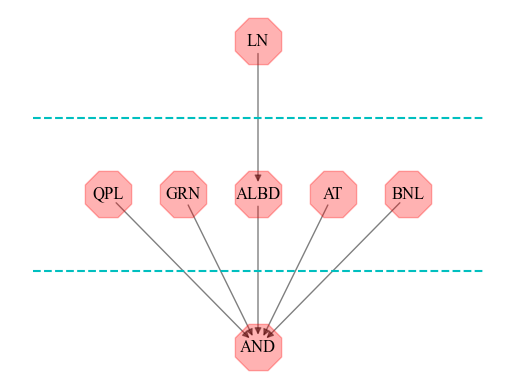

In [15]:

Matrix=np.array([[0] * len(Data1.index.values)]*len(Data2.index.values))
for i in range(0,len(Data1.index.values)):
    v=np.array([0]*i+[1]+[0]*(len(Data2.index.values)-i-1)).T
    for j in range(0,len(Data2)):
        if Data1.index.values[i]==Data2.index.values[j]:
            Matrix[j]=v
            break
Matrix=np.array(Matrix).T
print('维度交换矩阵',Matrix,sep='\n');pd.DataFrame(Matrix).to_csv('./随机占优积分过程/E维度交换矩阵.csv')

# 维度交换后的秩均值矩阵
zhijunzhi2=zhijunzhi1.dot(Matrix)
print('秩均值矩阵2',zhijunzhi2,sep='\n');pd.DataFrame(zhijunzhi2,index=pinpais,columns=Data2.index).to_csv('./随机占优积分过程/F秩均值矩阵2.csv')

# 可达矩阵1
keda1=np.array([[0] * len(pinpais)]*len(pinpais))
for i in range(0,len(pinpais)):
    for j in range(0,len(pinpais)):
        flag=True
        if i == j:
            keda1[i,j]=1
            continue
        for k in range(0,len(PLTS.keys())):
            if zhijunzhi2[i,k]<zhijunzhi2[j,k]:
                flag=False
        keda1[i,j]=1 if flag else 0

print('可达矩阵1',keda1,sep='\n');pd.DataFrame(keda1,index=pinpais,columns=pinpais).to_csv('./随机占优积分过程/G可达矩阵1.csv')

# 计算矩阵的布尔乘法
I=np.array([[0] * len(pinpais)]*len(pinpais))
for i in range(0,len(pinpais)):
    I[i,i]=1
R_I=keda1-I
Hasse_matrix=R_I-boolen_multi(R_I,R_I)
print('哈斯图矩阵1',Hasse_matrix,sep='\n');pd.DataFrame(Hasse_matrix,index=pinpais,columns=pinpais).to_csv('./随机占优积分过程/H哈斯图矩阵1.csv')

# 绘制初始Hasse图
Hasse_list=[]
for i in range(0,len(pinpais)):
    for j in range(0,len(pinpais)):
        if Hasse_matrix[i,j]==1:
            print(pinpais[i],'占优于',pinpais[j])
            Hasse_list.append((pinpais[i],pinpais[j]))
G = nx.DiGraph()
G.add_edges_from(Hasse_list) # 添加边
pos=\
    {'ALBD': [5,1],
    'AND':[5,0],
    'QPL':[3,1],
     'LN':[5,2],
    'BNL':[7,1],
     'GRN':[4,1],
     'AT':[6,1],
     'TB':[3,1]
    }
nx.draw_networkx_nodes(G, pos, node_size=1300, alpha=0.3, node_color='r', nodelist=G.nodes(),node_shape='8')
nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='Times New Roman')
plt.hlines(0.5, 2, 8, colors = "c", linestyles = "dashed") # 绘制y轴
plt.hlines(1.5, 2, 8, colors = "c", linestyles = "dashed") # 绘制y轴
plt.axis('off')
plt.show()

In [ ]:
S=np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4]])

Data1=['A','B','C','D']
Data2=['C','B','D','A']

# 1,2,3,4
# 3,2,4,1

Matrix=np.array([[0] * len(Data1)]*len(Data2))
for i in range(0,len(Data1)):
    v=np.array([0]*i+[1]+[0]*(len(Data1)-i-1)).T
    for j in range(0,len(Data2)):
        if Data1[i]==Data2[j]:
            Matrix[j]=v
            break
Matrix=np.array(Matrix).T
S2=np.dot(S,Matrix)
print(S,Matrix,np.dot(S,Matrix),sep='\n\n')

累计求和矩阵
[[1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1]]
累加变换矩阵2
[[ 2.57  3.86  6.43  8.23 15.94 21.08 22.37 26.87 29.87 35.01 38.87 41.44]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.29]
 [ 7.2  13.2  17.06 24.77 30.77 34.63 40.63 41.92 47.06 48.56 50.06 57.26]
 [ 1.29 10.29 19.29 23.79 27.65 35.15 42.65 51.65 60.65 69.65 77.36 81.22]
 [ 7.2  13.2  14.49 14.49 17.06 17.06 21.56 30.56 33.56 35.36 40.5  47.7 ]
 [ 5.4   8.4  14.83 23.83 32.83 40.33 49.33 54.73 62.23 69.73 76.16 85.16]
 [ 9.   12.   19.71 25.71 31.71 40.71 47.46 50.03 59.03 66.53 75.53 82.73]
 [ 5.4  13.11 18.25 21.25 22.54 25.11 27.68 33.68 34.97 37.97 39.47 39.47]]
可达矩阵2
[[1 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 1 1 0 1 0 0

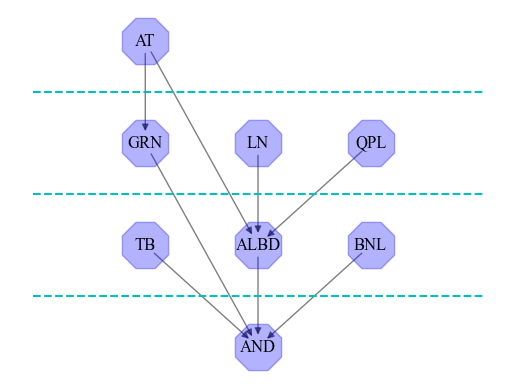

In [17]:
# 累计求和矩阵
leijiqiuhe=np.array([[0] * len(PLTS.keys())]*len(PLTS.keys()))
for i in range(0,len(PLTS.keys())):
    for j in range(0,len(PLTS.keys())):
        leijiqiuhe[i,j]=1 if i<=j else 0
print('累计求和矩阵',leijiqiuhe,sep='\n');pd.DataFrame(leijiqiuhe).to_csv('./随机占优积分过程/I累计求和矩阵.csv')

# 保留两位小数的累加秩均值矩阵
leijiabianhuan2=zhijunzhi2.dot(leijiqiuhe)
print('累加变换矩阵2',leijiabianhuan2,sep='\n');np.around(pd.DataFrame(leijiabianhuan2,index=pinpais,columns=Data2.index),2).to_csv('./随机占优积分过程/J累加变换矩阵2.csv')

# 可达矩阵
keda2=np.array([[0] * len(pinpais)]*len(pinpais))
for i in range(0,len(pinpais)):
    for j in range(0,len(pinpais)):
        flag=True
        if i == j:
            keda2[i,j]=0
        for k in range(0,len(PLTS.keys())):
            if leijiabianhuan2[i,k]<leijiabianhuan2[j,k]:
                flag=False
        keda2[i,j]=1 if flag else 0
print('可达矩阵2',keda2,sep='\n');pd.DataFrame(keda2,index=pinpais,columns=pinpais).to_csv('./随机占优积分过程/J可达矩阵2.csv')

# 计算矩阵的布尔乘法
I=np.array([[0] * len(pinpais)]*len(pinpais))
for i in range(0,len(pinpais)):
    I[i,i]=1
R_I=keda2-I
Hasse_matrix=R_I-boolen_multi(R_I,R_I)
print('哈斯图矩阵2',Hasse_matrix,sep='\n');pd.DataFrame(Hasse_matrix,index=pinpais,columns=pinpais).to_csv('./随机占优积分过程/K哈斯图矩阵2.csv')

# 绘制哈斯图
Hasse_list=[]
for i in range(0,len(pinpais)):
    for j in range(0,len(pinpais)):
        if Hasse_matrix[i,j]==1:
            print(pinpais[i],'占优于',pinpais[j])
            Hasse_list.append((pinpais[i],pinpais[j]))
G = nx.DiGraph()
G.add_edges_from(Hasse_list) # 添加边
pos=\
    {'ALBD': [2,1],
    'AND':[2,0],
    'QPL':[3,2],
     'LN':[2,2],
    'BNL':[3,1],
     'TB':[1,1],
     'GRN':[1,2],
     'AT':[1,3],
    }
plt.hlines(0.5, 0, 4, colors = "c", linestyles = "dashed") # 绘制y轴
plt.hlines(1.5, 0, 4, colors = "c", linestyles = "dashed") # 绘制y轴
plt.hlines(2.5, 0, 4, colors = "c", linestyles = "dashed") # 绘制y轴
nx.draw_networkx_nodes(G, pos, node_size=1300, alpha=0.3, node_color='b', nodelist=G.nodes(),node_shape='8')
nx.draw_networkx_edges(G, pos, alpha=0.5, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='Times New Roman')
plt.axis('off')
plt.show() # 绘制哈斯图 ```